<img src="images/cardboard.jpg">

##Making a profit off eBay: When and a Little Bit of How


Michael's mother is an avid eBay user. She sells all kinds of items on there - from clothing, to jewelry, and to most recently an old cell phone - but Curren, Charles, and he weren't so sure that that was the best way to make money while getting rid of goods you don't want. We decided to pursue looking into just whether or not eBay was a the right path to profitability. 

eBay has an extensive collection of information about all their auction listings. From time of listing and final price, to the feedback rating that sellers and buyers receive. We figured there was a way to consolidate and study this data to find something worth while. Considering Michael's mother recently sold a phone on there, we figured iPhones would be a good case study to look at. Many vendors now allow for trade-ins or store credit for devices one curently has, so we wanted to figure out when it was better to sell on eBay in comparison to selling back to a vendor. Below is a table of contents:

#Table of Contents
* [Making a profit off eBay: When and a little bit of How](#Making-a-profit-off-eBay:-When-and-a-Little-Bit-of-How)
* [P2. Making our Dataframe](#P2.-Making-our-Dataframe)
    * [2.1 Loading and merging the three dataframes](#2.1-Loading-and-merging-the-three-dataframes)
    * [2.2 Adding to and cleaning up our messy dataframe](#2.2-Adding-to-and-cleaning-up-our-messy-dataframe)
    * [2.3 Cleaning up the Dataframe some more](#2.3-Cleaning-up-the-Dataframe-some-more)

Continue you text_analysis.ipynb afterward to see more of the project!

In [52]:
%matplotlib inline
import numpy as np
import scipy as sp
from itertools import product
import json 
import csv
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
dark_colors = ["#99D699", "#B2B2B2",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

##P2. Making our Dataframe

To gather all the information we want about each auction, we have to combine a few jsons from different APIs. The first comes from eBay's Finding API, which allows us to amass up to 10000 item auctions about a specific type of item. The next gets more information about each individual item we got from the finding API in the Shopping API using the items itemId. Here we can get the seller's ID, and then we gather more information about the seller using the Shopping API again to get a user profile.

####2.1 Loading and merging the three dataframes

In [22]:

#dataframe for the finding API, will be merged with the shopping GetSingleItem
df_finding=pd.read_json("./data/completedItems.json")
df_finding.head()

,autoPay,charityId,condition,country,discountPriceInfo,galleryPlusPictureURL,galleryURL,globalId,isMultiVariationListing,itemId,listingInfo,location,paymentMethod,postalCode,primaryCategory,productId,returnsAccepted,sellingStatus,shippingInfo,subtitle,title,topRatedListing,viewItemURL
0,[false],NaN,"[{u'conditionId': [u'3000'], u'conditionDispla...",[US],NaN,NaN,[http://thumbs4.ebaystatic.com/m/mg6-FUGNDJgBS...,[EBAY-US],[false],[131642735687],"[{u'listingType': [u'Auction'], u'gift': [u'fa...","[South Salem,NY,USA]",[PayPal],[10590],"[{u'categoryId': [u'9355'], u'categoryName': [...",NaN,[false],"[{u'currentPrice': [{u'@currencyId': u'USD', u...","[{u'expeditedShipping': [u'true'], u'shippingT...",NaN,[iPhone 5s-32gb-Space Gray-unlocked],[false],[http://www.ebay.com/itm/iPhone-5s-32gb-Space-...
1,[false],NaN,"[{u'conditionId': [u'3000'], u'conditionDispla...",[US],NaN,NaN,[http://thumbs1.ebaystatic.com/m/mQAr2vyjNsA8_...,[EBAY-US],[false],[262126933108],"[{u'listingType': [u'Auction'], u'gift': [u'fa...","[Moody,AL,USA]",[PayPal],[35004],"[{u'categoryId': [u'9355'], u'categoryName': [...",NaN,[false],"[{u'currentPrice': [{u'@currencyId': u'USD', u...","[{u'expeditedShipping': [u'true'], u'shipToLoc...",NaN,[apple iphone 5s 32gb],[false],[http://www.ebay.com/itm/apple-iphone-5s-32gb-...
2,[false],NaN,"[{u'conditionId': [u'3000'], u'conditionDispla...",[US],NaN,NaN,[http://thumbs2.ebaystatic.com/m/maMtR-RvKQp5p...,[EBAY-US],[false],[252155964081],"[{u'listingType': [u'Auction'], u'gift': [u'fa...","[Seattle,WA,USA]",[PayPal],[98104],"[{u'categoryId': [u'9355'], u'categoryName': [...","[{u'@type': u'ReferenceID', u'__value__': u'16...",[false],"[{u'currentPrice': [{u'@currencyId': u'USD', u...","[{u'expeditedShipping': [u'false'], u'shipToLo...",NaN,[Apple iPhone 5s - 32GB SPACE GRAY AT&T],[false],[http://www.ebay.com/itm/Apple-iPhone-5s-32GB-...
3,[true],NaN,"[{u'conditionId': [u'3000'], u'conditionDispla...",[US],NaN,NaN,[http://thumbs1.ebaystatic.com/m/mDA7EYP3OjC0V...,[EBAY-US],[false],[171993101164],"[{u'listingType': [u'FixedPrice'], u'gift': [u...","[Rural Hall,NC,USA]",[PayPal],[27045],"[{u'categoryId': [u'9355'], u'categoryName': [...","[{u'@type': u'ReferenceID', u'__value__': u'16...",[false],"[{u'currentPrice': [{u'@currencyId': u'USD', u...","[{u'expeditedShipping': [u'false'], u'shipToLo...",NaN,[Apple iPhone 5s 32GB CUSTOM BlacK/Silver Veri...,[false],[http://www.ebay.com/itm/Apple-iPhone-5s-32GB-...
4,[false],NaN,"[{u'conditionId': [u'3000'], u'conditionDispla...",[US],NaN,NaN,[http://thumbs2.ebaystatic.com/m/mOHoyXPQLsCpG...,[EBAY-US],[false],[272034040829],"[{u'listingType': [u'AuctionWithBIN'], u'buyIt...","[Boca Raton,FL,USA]",[PayPal],[33487],"[{u'categoryId': [u'9355'], u'categoryName': [...","[{u'@type': u'ReferenceID', u'__value__': u'16...",[true],"[{u'currentPrice': [{u'@currencyId': u'USD', u...","[{u'expeditedShipping': [u'true'], u'shippingT...",NaN,[Apple iPhone 5s - 32GB - Space Gray (AT&T) Sm...,[false],[http://www.ebay.com/itm/Apple-iPhone-5s-32GB-...


In [23]:
# do the same for the getSingleItem call, and rename itemId to make the column names align
df_getsingleitem = pd.read_json("./data/getSingleItem.json")
df_getsingleitem=df_getsingleitem.rename(columns = {'ItemID':'itemId'})
df_getsingleitem.head()

,AutoPay,AvailableForPickupDropOff,BestOfferEnabled,BidCount,BuyItNowAvailable,BuyItNowPrice,Charity,ConvertedBuyItNowPrice,ConvertedCurrentPrice,Country,CurrentPrice,DiscountPriceInfo,EligibleForPickupDropOff,EndTime,ExcludeShipToLocation,GalleryURL,GlobalShipping,HandlingTime,HighBidder,HitCount,IntegratedMerchantCreditCardEnabled,itemId,ListingStatus,ListingType,Location,LotSize,MinimumToBid,NewBestOffer,PaymentAllowedSite,PaymentMethods,PictureURL,PostalCode,PrimaryCategoryID,PrimaryCategoryIDPath,PrimaryCategoryName,ProductID,Quantity,QuantityAvailableHint,QuantitySold,QuantitySoldByPickupInStore,QuantityThreshold,ReserveMet,ReturnPolicy,SKU,Seller,ShipToLocations,Site,StartTime,Storefront,Subtitle,TimeLeft,Title,TopRatedListing,ViewItemURLForNaturalSearch
0,False,NaN,True,0,NaN,NaN,NaN,NaN,"{u'CurrencyID': u'USD', u'Value': 300.0}",US,"{u'CurrencyID': u'USD', u'Value': 300.0}",NaN,NaN,2015-11-10T00:51:29.000Z,NaN,http://thumbs1.ebaystatic.com/pict/17199002700...,False,2,NaN,33,False,171990027000,Completed,FixedPriceItem,"Birmingham, Alabama",NaN,NaN,False,[],[PayPal],[http://i.ebayimg.com/00/s/MTIwMFgxNjAw/z/V6wA...,35209,9355,15032:9355,Cell Phones & Accessories:Cell Phones & Smartp...,"{u'Type': u'Reference', u'Value': u'168553370'}",1,NaN,0,0,NaN,NaN,{u'ReturnsAccepted': u'ReturnsNotAccepted'},NaN,"{u'FeedbackRatingStar': u'None', u'UserID': u'...",[US],US,2015-11-05T21:56:34.000Z,NaN,NaN,PT0S,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,NaN,http://www.ebay.com/itm/Apple-iPhone-5s-32GB-S...
1,False,NaN,True,0,NaN,NaN,NaN,NaN,"{u'CurrencyID': u'USD', u'Value': 75.0}",US,"{u'CurrencyID': u'USD', u'Value': 75.0}",NaN,NaN,2015-11-24T18:45:39.000Z,NaN,http://thumbs1.ebaystatic.com/pict/26215731758...,True,1,"{u'FeedbackRatingStar': u'Blue', u'FeedbackPri...",200,False,262157317580,Completed,FixedPriceItem,"Dillon, Colorado",NaN,NaN,False,[],[PayPal],[http://i.ebayimg.com/00/s/MTYwMFgxMjAw/z/p6sA...,80435,9355,15032:9355,Cell Phones & Accessories:Cell Phones & Smartp...,"{u'Type': u'Reference', u'Value': u'168534287'}",1,NaN,1,0,NaN,NaN,{u'ReturnsAccepted': u'ReturnsNotAccepted'},NaN,"{u'FeedbackRatingStar': u'None', u'UserID': u'...","[US, CA, GB, DK, RO, SK, BG, CZ, FI, HU, LV, L...",US,2015-11-23T19:17:05.000Z,NaN,NaN,PT0S,Apple iPhone 5s - 32GB - Gray AT&T Locked,NaN,http://www.ebay.com/itm/Apple-iPhone-5s-32GB-G...
2,False,NaN,False,54,NaN,NaN,NaN,NaN,"{u'CurrencyID': u'USD', u'Value': 268.0}",US,"{u'CurrencyID': u'USD', u'Value': 268.0}",NaN,NaN,2015-11-11T15:24:14.000Z,NaN,http://thumbs3.ebaystatic.com/pict/27203841300...,True,2,"{u'FeedbackRatingStar': u'Yellow', u'FeedbackP...",403,False,272038413006,Completed,Chinese,"Los Angeles, California",NaN,"{u'CurrencyID': u'USD', u'Value': 273.0}",False,[],[PayPal],[http://i.ebayimg.com/00/s/MTYwMFgxMjAw/z/01EA...,90038,9355,15032:9355,Cell Phones & Accessories:Cell Phones & Smartp...,"{u'Type': u'Reference', u'Value': u'170104083'}",1,NaN,1,0,NaN,NaN,{u'ReturnsAccepted': u'ReturnsNotAccepted'},NaN,"{u'FeedbackRatingStar': u'Turquoise', u'UserID...","[US, CA, GB, AU, IE, MX, NZ, SG, AE]",US,2015-11-06T15:24:14.000Z,NaN,NaN,PT0S,Apple iPhone 5s - 32GB - Gold (Unlocked) Smart...,NaN,http://www.ebay.com/itm/Apple-iPhone-5s-32GB-G...
3,False,NaN,True,0,NaN,NaN,NaN,NaN,"{u'CurrencyID': u'USD', u'Value': 279.99}",US,"{u'CurrencyID': u'USD', u'Value': 279.99}",NaN,NaN,2015-11-28T16:12:03.000Z,"[APO/FPO, PO Box, South America, MO, VN, BN, K...",http://thumbs4.ebaystatic.com/pict/22192908739...,True,1,"{u'FeedbackRatingStar': u'Yellow', u'FeedbackP...",175,False,221929087395,Completed,FixedPriceItem,"Feasterville-Trevose, Pennsylvania",NaN,NaN,False,[],[PayPal],[http://i.ebayimg.com/00/s/MTM2OVg4NTQ=/z/lk8A...,19053,9355,15032:9355,Cell Phones & Accessories:Cell Phones & Smartp...,"{u'Type': u'Reference', u'Value': u'170038755'}",1,NaN,1,0,NaN,NaN,{u'ReturnsAccepted': u'ReturnsNotAccepted'},NaN,"{u'FeedbackRatingStar': u'Red', u'UserID': u'e...","[US, CA, GB, DK, RO, SK, BG, C

In [24]:
df_UserProfile=pd.read_json("./data/getUserProfile.json")
df_UserProfile.head()

,Ack,Build,Errors,FeedbackHistory,Timestamp,User,Version
0,Success,E949_CORE_APILW_17769283_R1,NaN,"{u'NeutralFeedbackPeriods': [{u'Count': 0, u'P...",2015-12-07T23:07:04.459Z,"{u'Status': u'Confirmed', u'PositiveFeedbackPe...",949
1,Success,E949_CORE_APILW_17769283_R1,NaN,"{u'NeutralFeedbackPeriods': [{u'Count': 0, u'P...",2015-12-07T23:07:05.036Z,"{u'Status': u'Confirmed', u'PositiveFeedbackPe...",949
2,Success,E949_CORE_APILW_17769283_R1,NaN,"{u'NeutralFeedbackPeriods': [{u'Count': 0, u'P...",2015-12-07T23:07:05.327Z,"{u'Status': u'Confirmed', u'PositiveFeedbackPe...",949
3,Success,E949_CORE_APILW_17769283_R1,NaN,"{u'NeutralFeedbackPeriods': [{u'Count': 0, u'P...",2015-12-07T23:07:06.527Z,"{u'Status': u'Confirmed', u'PositiveFeedbackPe...",949
4,Success,E949_CORE_APILW_17769283_R1,NaN,"{u'NeutralFeedbackPeriods': [{u'Count': 0, u'P...",2015-12-07T23:07:07.159Z,"{u'Status': u'Confirmed', u'PositiveFeedbackPe...",949


We define a function to expand cells that are actually dictionaries into new columns based on dict keys. This is needed for access to item and user ids to merge the dataframes from the different APIs. We realized a lot of the information we wanted was still actually hidden, including the required User and Seller information!

In [25]:
"""
Function to take each cell in a column when the cell is actually a dictionary. 
Each value in the dictionary is added to a new column of the dataframe based on its key
""" 

#how about this guy!!!
def column_dict_expander(df,column):
    for key in df[column][0].keys():
        templist = []
        print key
        counter = 0
        for i in df.index:
            counter +=1
            
            ## get each dictionary down the column and pull out each individual key to make a column
            dictionary = df[column][i]
            if isinstance(dictionary,dict):
                if key in dictionary.keys():
                    val = dictionary[key]
            else:
                val = 'NaN'
            templist.append(val)
            
        ## add the column
        df[key] = templist
    df = df.drop(column, 1)
    return df

We now use the function just defined above to add columns to our dataframe. Those columns come from "Seller" and "User" in the getUserprofile df. The printed output are the columns that we revealed by doing so.

In [26]:
# This is to expand some of the columns that have dicitonaries of information.
# I go into each dictionary and make a new column based on each key in the dictionary
# with the function I defined above 

df_getsingleitem = column_dict_expander(df_getsingleitem,'Seller')
df_UserProfile = column_dict_expander(df_UserProfile,'User')


FeedbackRatingStar
UserID
FeedbackScore
PositiveFeedbackPercent
Status
PositiveFeedbackPercent
SellerBusinessType
NewUser
UserID
FeedbackRatingStar
FeedbackPrivate
FeedbackScore
FeedbackDetailsURL
SellerItemsURL
RegistrationSite
RegistrationDate


We then ensure that the column we would like to merge over has the exact same type and identification and then merge.

In [27]:
#turns item ID entries from 1-element lists to just the contents inside
df_finding['itemId'] = df_finding.itemId.apply(lambda r: r[0])
#convert type of item ID entries to ints
df_finding['itemId'] = df_finding.itemId.apply(lambda r: int(r))

df_items = pd.merge(df_finding, df_getsingleitem, on='itemId', how='inner')


In [28]:
## MERGING THE FIRST TWO WITH THE ONE ABOUT THE SELLER

df_total = pd.merge(df_items, df_UserProfile, on='UserID', how='inner')

In [29]:
df_total.head()
#print len(df_total.index)

,autoPay,charityId,condition,country,discountPriceInfo,galleryPlusPictureURL,galleryURL,globalId,isMultiVariationListing,itemId,listingInfo,location,paymentMethod,postalCode,primaryCategory,productId,returnsAccepted,sellingStatus,shippingInfo,subtitle,title,topRatedListing,viewItemURL,AutoPay,AvailableForPickupDropOff,BestOfferEnabled,BidCount,BuyItNowAvailable,BuyItNowPrice,Charity,ConvertedBuyItNowPrice,ConvertedCurrentPrice,Country,CurrentPrice,DiscountPriceInfo,EligibleForPickupDropOff,EndTime,ExcludeShipToLocation,GalleryURL,GlobalShipping,HandlingTime,HighBidder,HitCount,IntegratedMerchantCreditCardEnabled,ListingStatus,ListingType,Location,LotSize,MinimumToBid,NewBestOffer,PaymentAllowedSite,PaymentMethods,PictureURL,PostalCode,PrimaryCategoryID,PrimaryCategoryIDPath,PrimaryCategoryName,ProductID,Quantity,QuantityAvailableHint,QuantitySold,QuantitySoldByPickupInStore,QuantityThreshold,ReserveMet,ReturnPolicy,SKU,ShipToLocations,Site,StartTime,Storefront,Subtitle,TimeLeft,Title,TopRatedListing,ViewItemURLForNaturalSearch,FeedbackRatingStar_x,UserID,FeedbackScore_x,PositiveFeedbackPercent_x,Ack,Build,Errors,FeedbackHistory,Timestamp,Version,Status,PositiveFeedbackPercent_y,SellerBusinessType,NewUser,FeedbackRatingStar_y,FeedbackPrivate,FeedbackScore_y,FeedbackDetailsURL,SellerItemsURL,RegistrationSite,RegistrationDate
0,[false],NaN,"[{u'conditionId': [u'3000'], u'conditionDispla...",[US],NaN,NaN,[http://thumbs4.ebaystatic.com/m/mg6-FUGNDJgBS...,[EBAY-US],[false],131642735687,"[{u'listingType': [u'Auction'], u'gift': [u'fa...","[South Salem,NY,USA]",[PayPal],[10590],"[{u'categoryId': [u'9355'], u'categoryName': [...",NaN,[false],"[{u'currentPrice': [{u'@currencyId': u'USD', u...","[{u'expeditedShipping': [u'true'], u'shippingT...",NaN,[iPhone 5s-32gb-Space Gray-unlocked],[false],[http://www.ebay.com/itm/iPhone-5s-32gb-Space-...,False,NaN,False,41,NaN,NaN,NaN,NaN,"{u'CurrencyID': u'USD', u'Value': 202.09}",US,"{u'CurrencyID': u'USD', u'Value': 202.09}",NaN,NaN,2015-11-09T01:48:14.000Z,NaN,http://thumbs4.ebaystatic.com/pict/13164273568...,False,2,"{u'FeedbackRatingStar': u'Blue', u'FeedbackPri...",190,False,Completed,Chinese,"South Salem, New York",NaN,"{u'CurrencyID': u'USD', u'Value': 204.59}",False,[],[PayPal],[http://i.ebayimg.com/00/s/OTk5WDc0OQ==/z/lDQA...,10590,9355,15032:9355,Cell Phones & Accessories:Cell Phones & Smartp...,NaN,1,NaN,1,0,NaN,NaN,{u'ReturnsAccepted': u'ReturnsNotAccepted'},NaN,[US],US,2015-11-02T01:48:14.000Z,NaN,NaN,PT0S,iPhone 5s-32gb-Space Gray-unlocked,NaN,http://www.ebay.com/itm/iPhone-5s-32gb-Space-G...,Yellow,jdwein1980,19,100.0,Success,E949_CORE_APILW_17769283_R1,NaN,"{u'NeutralFeedbackPeriods': [{u'Count': 0, u'P...",2015-12-07T23:40:31.429Z,949,Confirmed,100,Undefined,False,Yellow,False,19,http://feedback.ebay.com/ws/eBayISAPI.dll?View...,http://search.ebay.com/?sass=jdwein1980&amp;ht=-1,US,2004-03-25T21:44:54.000Z
1,[false],NaN,"[{u'conditionId': [u'3000'], u'conditionDispla...",[US],NaN,NaN,[http://thumbs1.ebaystatic.com/m/mQAr2vyjNsA8_...,[EBAY-US],[false],262126933108,"[{u'listingType': [u'Auction'], u'gift': [u'fa...","[Moody,AL,USA]",[PayPal],[35004],"[{u'categoryId': [u'9355'], u'categoryName': [...",NaN,[false],"[{u'currentPrice': [{u'@currencyId': u'USD', u...","[{u'expeditedShipping': [u'true'], u'shipToLoc...",NaN,[apple iphone 5s 32gb],[false],[http://www.ebay.com/itm/apple-iphone-5s-32gb-...,False,NaN,False,4,NaN,NaN,NaN,NaN,"{u'CurrencyID': u'USD', u'Value': 260.0}",US,"{u'CurrencyID': u'USD', u'Value': 260.0}",NaN,NaN,2015-11-09T01:47:58.000Z,NaN,http://thumbs1.ebaystatic.com/pict/26212693310...,False,3,"{u'FeedbackRatingStar': u'Blue', u'FeedbackPri...",32,False,Completed,Chinese,"Moody, Alabama",NaN,"{u'CurrencyID': u'USD', u'Value': 265.0}",False,[],[PayPal],[http://i.ebayimg.com/00/s/MTAwMFg3NTA=/z/djoA...,35004,9355,15032:9355,Cell Phones & Accessories:Cell Phones & Smartp...,NaN,1,NaN,1,0,NaN,NaN,{u'ReturnsAccepted': u'ReturnsNotAccepted'},NaN,[US],US,2015-11-04T01:47:5

####2.2 Adding to and cleaning up our messy dataframe




**NEXT, we will expand some more columns and delete others that we just don't need to do our analysis. This could even come at the end once we figure out which aren't useful, but we do some of it now.**

We make a few functions that will help clean up the data to put it in usable form. The purpose of each is outlined in the heading of the function. We need these in order to be able to do something with the data later. If they are not of the same form, calculations and visualizations fail, as we learned through the process.

In [30]:
"""
This function removes the array brackets from entries that are 1 element arrays. We can't do most of the
manipulation we want without doing so.

Input: a list r. if the list is 1D, return the first element. Else return the whole list again
"""
def de_list(r):
    if type(r) == list and len(r) == 1:
        return r[0]
    elif type(r) == list and len(r) == 0:
        return None
    elif type(r) == list and len(r) > 1:
        return r
    elif type(r) !=list:
        return r
    

In [31]:
"""
Function to change all strings that are supposed to represent bools to actual bools. Thanks eBay for being more
of a pain in the butt!
"""

def to_bool(df,col):
    for i in df.index:
        if df.loc[i,col] == u'true' or df.loc[i,col] == 'true':
            df.loc[i,col] = True
        elif df.loc[i,col] == u'false' or df.loc[i,col] == 'false':
            df.loc[i,col] = False
    return

In [32]:
"""
Function to change Column to include just one desired value in a dictionary. For example, each cell in the CurrentPrice
column is actually a dictionary with some redundant entries irrelevant to column title. We only want 
one of those entries -- the one that is actually the current price of the item at the end of the auction.

tl;dr - getting just one value from a column and keeping that column name rather than expanding a whole dictionary.

Takes dataframe df and column from that df, col
"""

def dict_simplify(df,col, key):
    for i in df.index:
        if pd.isnull(df[col].values[i]) == False:
            df[col].values[i] = df[col].values[i][key]
        else:
            continue
    return 

Now we put those functions to use! We expand a bunch of items and make our pseudo-bools and into real bools.

In [33]:
## Here we employ the functions written above on a variety of columns to either expand a dictionary into
# multiple columns or simply simplify a column to just one value in a dictionary. We also create a new 
# columns related to the number of photos of the item posted by the seller.

df_total['nPhotos'] = df_total['PictureURL'].map(lambda r: len(r))
df_total['nPaymentMethods'] = df_total['PaymentMethods'].map(lambda r: len(r))
df_total['nShippingCountries'] = df_total['ShipToLocations'].map(lambda r: len(r) if r != 'Worldwide' else 200)

for col in df_total.columns:
    df_total[col] = df_total[col].apply(de_list)

##expand every key in dict into new column
df_total = column_dict_expander(df_total,'condition')
df_total = column_dict_expander(df_total,'listingInfo')
df_total = column_dict_expander(df_total,'primaryCategory')
df_total = column_dict_expander(df_total,'shippingInfo')
df_total = column_dict_expander(df_total,'ReturnPolicy')


##specific dict value assigned to column based on Key
dict_simplify(df_total,'CurrentPrice', u'Value')
dict_simplify(df_total,'BuyItNowPrice', u'Value')
dict_simplify(df_total,'MinimumToBid', u'Value')
dict_simplify(df_total,'ProductID', u'Value')
dict_simplify(df_total,'sellingStatus', u'sellingState')


for col in df_total.columns:
    df_total[col] = df_total[col].apply(de_list)  

##convert string bools to actual bools
to_bool(df_total,'returnsAccepted')
to_bool(df_total,'bestOfferEnabled')
to_bool(df_total,'topRatedListing')
to_bool(df_total,'buyItNowAvailable')
to_bool(df_total,'expeditedShipping')
to_bool(df_total,'oneDayShippingAvailable')


conditionId
conditionDisplayName
listingType
gift
bestOfferEnabled
startTime
buyItNowAvailable
endTime
categoryId
categoryName
expeditedShipping
shippingType
handlingTime
oneDayShippingAvailable
shipToLocations
ReturnsAccepted




###2.3 Cleaning up the Dataframe some more

We now have to delete a bunch of columns we don't need and make some new ones off of information that we think may be useful. For example, we have an entire column of feedback history, but we could quantize some interesting stuff out of that. We pull out specifics like feedback over the most recent 30 days for that seller, as it may affect buyer's habits differently than feedback gotten a year ago. We'll see.

In [34]:
df_total.head()

,autoPay,charityId,country,discountPriceInfo,galleryPlusPictureURL,galleryURL,globalId,isMultiVariationListing,itemId,location,paymentMethod,postalCode,productId,returnsAccepted,sellingStatus,subtitle,title,topRatedListing,viewItemURL,AutoPay,AvailableForPickupDropOff,BestOfferEnabled,BidCount,BuyItNowAvailable,BuyItNowPrice,Charity,ConvertedBuyItNowPrice,ConvertedCurrentPrice,Country,CurrentPrice,DiscountPriceInfo,EligibleForPickupDropOff,EndTime,ExcludeShipToLocation,GalleryURL,GlobalShipping,HandlingTime,HighBidder,HitCount,IntegratedMerchantCreditCardEnabled,ListingStatus,ListingType,Location,LotSize,MinimumToBid,NewBestOffer,PaymentAllowedSite,PaymentMethods,PictureURL,PostalCode,...,SKU,ShipToLocations,Site,StartTime,Storefront,Subtitle,TimeLeft,Title,TopRatedListing,ViewItemURLForNaturalSearch,FeedbackRatingStar_x,UserID,FeedbackScore_x,PositiveFeedbackPercent_x,Ack,Build,Errors,FeedbackHistory,Timestamp,Version,Status,PositiveFeedbackPercent_y,SellerBusinessType,NewUser,FeedbackRatingStar_y,FeedbackPrivate,FeedbackScore_y,FeedbackDetailsURL,SellerItemsURL,RegistrationSite,RegistrationDate,nPhotos,nPaymentMethods,nShippingCountries,conditionId,conditionDisplayName,listingType,gift,bestOfferEnabled,startTime,buyItNowAvailable,endTime,categoryId,categoryName,expeditedShipping,shippingType,handlingTime,oneDayShippingAvailable,shipToLocations,ReturnsAccepted
0,false,NaN,US,NaN,NaN,http://thumbs4.ebaystatic.com/m/mg6-FUGNDJgBSJ...,EBAY-US,false,131642735687,"South Salem,NY,USA",PayPal,10590,NaN,False,EndedWithSales,NaN,iPhone 5s-32gb-Space Gray-unlocked,False,http://www.ebay.com/itm/iPhone-5s-32gb-Space-G...,False,NaN,False,41,NaN,NaN,NaN,NaN,"{u'CurrencyID': u'USD', u'Value': 202.09}",US,202.09,NaN,NaN,2015-11-09T01:48:14.000Z,NaN,http://thumbs4.ebaystatic.com/pict/13164273568...,False,2,"{u'FeedbackRatingStar': u'Blue', u'FeedbackPri...",190,False,Completed,Chinese,"South Salem, New York",NaN,204.59,False,None,PayPal,[http://i.ebayimg.com/00/s/OTk5WDc0OQ==/z/lDQA...,10590,...,NaN,US,US,2015-11-02T01:48:14.000Z,NaN,NaN,PT0S,iPhone 5s-32gb-Space Gray-unlocked,NaN,http://www.ebay.com/itm/iPhone-5s-32gb-Space-G...,Yellow,jdwein1980,19,100.0,Success,E949_CORE_APILW_17769283_R1,NaN,"{u'NeutralFeedbackPeriods': [{u'Count': 0, u'P...",2015-12-07T23:40:31.429Z,949,Confirmed,100.0,Undefined,False,Yellow,False,19,http://feedback.ebay.com/ws/eBayISAPI.dll?View...,http://search.ebay.com/?sass=jdwein1980&amp;ht=-1,US,2004-03-25T21:44:54.000Z,3,1,1,3000,Used,Auction,false,False,2015-11-02T01:48:14.000Z,False,2015-11-09T01:48:14.000Z,9355,Cell Phones & Smartphones,True,Calculated,2,False,US,ReturnsNotAccepted
1,false,NaN,US,NaN,NaN,http://thumbs1.ebaystatic.com/m/mQAr2vyjNsA8_c...,EBAY-US,false,262126933108,"Moody,AL,USA",PayPal,35004,NaN,False,EndedWithSales,NaN,apple iphone 5s 32gb,False,http://www.ebay.com/itm/apple-iphone-5s-32gb-/...,False,NaN,False,4,NaN,NaN,NaN,NaN,"{u'CurrencyID': u'USD', u'Value': 260.0}",US,260.00,NaN,NaN,2015-11-09T01:47:58.000Z,NaN,http://thumbs1.ebaystatic.com/pict/26212693310...,False,3,"{u'FeedbackRatingStar': u'Blue', u'FeedbackPri...",32,False,Completed,Chinese,"Moody, Alabama",NaN,265.00,False,None,PayPal,[http://i.ebayimg.com/00/s/MTAwMFg3NTA=/z/djoA...,35004,...,NaN,US,US,2015-11-04T01:47:58.000Z,NaN,NaN,PT0S,apple iphone 5s 32gb,NaN,http://www.ebay.com/itm/apple-iphone-5s-32gb-/...,Purple,forwhlrcr1965,565,100.0,Success,E949_CORE_APILW_17769283_R1,NaN,"{u'NeutralFeedbackPeriods': [{u'Count': 24, u'...",2015-12-07T23:25:19.360Z,949,Confirmed,100.0,Private,False,Purple,False,566,http://feedback.ebay.com/ws/eBayISAPI.dll?View...,http://search.ebay.com/?sass=forwhlrcr1965&amp...,US,2008-03-16T20:31:23.000Z,2,1,1,3000,Used,Auction,false,False,2015-11-04T01:47:58.000Z,False,2015-11-09T01:47:58.000Z,9355,Cell Phones & Smartphones,True,Free,3,False,US,ReturnsNotAccepted
2,false,NaN,US,NaN,NaN,http://thumbs2.ebaystatic.com/m/maMtR-RvKQp5pu...,EBAY-US,false,252155964081,"Seattle,WA,USA",PayPal,98104,"{u'@type':

In [35]:
#This is to get a bool about the rating and whether or not they made their ratings visible to see


def avg_rating(elt):
    total=0
    #print elt
    if elt['AverageRatingDetails'] != []:
        total = 0
        length = len(elt['AverageRatingDetails'])
        for j in range(length):
            total += elt['AverageRatingDetails'][j]['Rating']
            avg = total/length
        return avg
    else:
        return float('NaN')



df_total['RatingsPresent'] = df_total['FeedbackHistory'].map(lambda r: False if r['AverageRatingDetails'] == [] else True)
df_total['AverageRating'] = df_total['FeedbackHistory'].map(avg_rating)

We delete the columns that are irrelevant to our analysis. For example, DiscountPriceInfo tells us no information about our data, because none of our auctions have discounted prices.

In [36]:
#This is to add columns for the number of negative and positive reviews in the past 30 and 365 days

for key in df_total['FeedbackHistory'][0].keys():
    templist_30neg = []
    templist_30pos = []
    templist_365neg = []
    templist_365pos = []
    
    if key == u'NegativeFeedbackPeriods':
        for i in df_total.index:
            
            ##get only negative feedback period
            neg_dict_array = df_total['FeedbackHistory'][i][key]
            neg_dict_30period = neg_dict_array[2][u'PeriodInDays']
            neg_dict_30count = neg_dict_array[2][u'Count']
            neg_dict_365count = neg_dict_array[4][u'Count']
            templist_30neg.append(neg_dict_30count)
            templist_365neg.append(neg_dict_365count)

        df_total['NegFeedback30Day'] = templist_30neg
        df_total['NegFeedback365Day'] = templist_365neg
        
    if key == u'PositiveFeedbackPeriods':
        for i in df_total.index:
            
            ##get only positive feedback period
            pos_dict_array = df_total['FeedbackHistory'][i][key]
            pos_dict_30period = pos_dict_array[2][u'PeriodInDays']
            pos_dict_30count = pos_dict_array[2][u'Count']
            pos_dict_365count = pos_dict_array[4][u'Count']
            templist_30pos.append(pos_dict_30count)
            templist_365pos.append(pos_dict_365count)
        
        df_total['PosFeedback30Day'] = templist_30pos
        df_total['PosFeedback365Day'] = templist_365pos
        
df_total = df_total.drop('FeedbackHistory', 1)

We realized we had many columns that didn't have much input data, being a lot of NaNs, data that was duplicated from the multiple API calls, and data that wasn't quantifiable or related to buyer's decisions. So we pull all those out!

In [37]:
del df_total['autoPay'], df_total['charityId'], df_total['discountPriceInfo'], df_total['galleryPlusPictureURL']
del df_total['galleryURL'], df_total['isMultiVariationListing'], df_total['location'], df_total['productId']
del df_total['subtitle'], df_total['viewItemURL'], df_total['Charity'], df_total['ConvertedBuyItNowPrice']
del df_total['ConvertedCurrentPrice'], df_total['Country'], df_total['DiscountPriceInfo'], df_total['ExcludeShipToLocation']
del df_total['GalleryURL'], df_total['LotSize'], df_total['PictureURL'], df_total['PaymentAllowedSite']
del df_total['SKU'], df_total['Site'], df_total['Storefront'], df_total['Subtitle'], df_total['TimeLeft']
del df_total['title'], df_total['ViewItemURLForNaturalSearch'], df_total['Build'], df_total['Ack'], df_total['Errors']
del df_total['FeedbackDetailsURL'], df_total['SellerItemsURL'], df_total['RegistrationSite'], df_total['RegistrationDate']
del df_total['conditionDisplayName'], df_total['listingType'], df_total['gift'], df_total['startTime'], df_total['endTime']
del df_total['categoryName'], df_total['BuyItNowAvailable'], df_total['handlingTime'], df_total['shipToLocations']
del df_total['ReturnsAccepted'], df_total['PrimaryCategoryIDPath'], df_total['PrimaryCategoryName'], df_total['categoryId']
del df_total['Timestamp'], df_total['Version'], df_total['PaymentMethods'], df_total['PostalCode'], df_total['TopRatedListing']
del df_total['EligibleForPickupDropOff'], df_total['FeedbackRatingStar_y'], df_total['FeedbackScore_y']
del df_total['PositiveFeedbackPercent_y'], df_total['returnsAccepted'], df_total['NewBestOffer']
del df_total['QuantityAvailableHint'], df_total['QuantitySold'], df_total['QuantitySoldByPickupInStore'], df_total['HighBidder']
del df_total['globalId'], df_total['IntegratedMerchantCreditCardEnabled'], df_total['PrimaryCategoryID']
del df_total['FeedbackRatingStar_x'], df_total['Status'], df_total['FeedbackPrivate']

We then remove even more unnecessary information from each of the columns. For example, on CurrentPrice, we only want the value in the dictionary and not the whole dictionary. 

In [38]:
df_test = df_total.copy()

In [39]:
print df_total['shippingType'].unique()
df_test['ListingType'] = df_test['ListingType'].map({'Chinese': 0, 'FixedPriceItem': 1})

[u'Calculated' u'Free' u'Flat' u'FlatDomesticCalculatedInternational'
 u'FreePickup' u'CalculatedDomesticFlatInternational' u'NotSpecified']


In [41]:
def filterfunc(key,elt):
    if elt == key and key in elt:
        return 1
    else:
        return 0

####2.4 Mapping values to string data that is important


Some of the data we have, like which type of auction it is, may be important in the buyer's decision making process, but it wasn't initially a number, so it was hard to quantify some of the string information. We map these strings to positive associated values (1) and negative/neutral (0) to be added to our analysis as hopefully potential indicators. We realized we could lose data this way by consolidating multiple categories down to just 2, so we made a larger map for some, or took only the important aspect of the string that we wanted and made it a new variable, such as counting the number of payment options available rather than mapping to all 20 of them.

In [42]:
import time

df_clean = df_total.copy() 

#defines which type of auction
df_clean['ListingType'] = df_clean['ListingType'].map({'Chinese': 1, 'FixedPriceItem': 0})

#We made A nPaymentMethods to supplement this to not lose data
df_clean['paymentMethod'] = df_clean['paymentMethod'].apply(lambda x: filterfunc('PayPal',x))

#US or not
df_clean['country'] = df_clean['country'].apply(lambda x: filterfunc('US',x))

##Sold or not
df_clean['sellingStatus'] =df_clean['sellingStatus'].apply(lambda x: 1 if x == 'EndedWithSales' else 0)

##Available for droppoff or not
df_clean['AvailableForPickupDropOff'] = df_clean['AvailableForPickupDropOff'].apply(lambda x: 0 if np.isnan(x) else 1)


###Mapping of seller business types
df_clean['SellerBusinessType'] = df_clean['SellerBusinessType'].map({'Commercial':0,'Private':1,'Undefined':2,'CustomCode':3})

###Mapping of all shipping types
df_clean['shippingType'] = df_clean['shippingType'].map({'Free':0, 'Flat':1, 'Calculated':2,
                                                         'FlatDomesticCalculatedInternational':3, 
                                                         'CalculatedDomesticFlatInternational':4 , 'Freight':5, 'FreightFlat':6,
                                                        'NotSpecified':8})

###How many limited to buy at once? For us this was only 0 or 10
df_clean['QuantityThreshold'] = df_clean['QuantityThreshold'].apply(lambda x: 0 if np.isnan(x) else x)

###Map of condition Ids
df_clean['conditionId'] = df_clean['conditionId'].map({'1000':9, '1500':8, '1750':7, '2000':6, '2500':5,'3000':4, '4000':3, '5000':2, '6000':1, '7000':0})

##calculating time
df_clean['EndTime'] = df_clean['EndTime'].apply(lambda x: np.datetime64(x))
df_clean['StartTime'] = df_clean['StartTime'].apply(lambda x: np.datetime64(x))

##making auctionlength column
df_clean['auctionLength'] = (df_clean['EndTime'] - df_clean['StartTime']).astype('timedelta64[h]')

del df_clean['EndTime'], df_clean['StartTime']
#CurrentPrice, start-end, HandlingTime, MinimumToBid, FeedbackScore_x, PositiveFeedbackPercent_x
#conditionId, Quantity


#because each auction we are dealing with is completed and because the FeedbackScore etc was a duplicate, we say
df_clean=df_clean.rename(columns = {'CurrentPrice':'FinalPrice', 'PositiveFeedbackPercent_x': 'PositiveFeedbackPercent',
                                   'FeedbackScore_x':'FeedbackScore'})

In [43]:
df_clean = df_clean[pd.isnull(df_clean.HandlingTime) == False]
counter = 0
for i in df_clean.index:
    if np.isnan(df_clean.HandlingTime[i]) == True:
        counter+=1
print counter
df_clean.head()

0


,country,itemId,paymentMethod,postalCode,sellingStatus,topRatedListing,AutoPay,AvailableForPickupDropOff,BestOfferEnabled,BidCount,BuyItNowPrice,FinalPrice,GlobalShipping,HandlingTime,HitCount,ListingStatus,ListingType,Location,MinimumToBid,ProductID,Quantity,QuantityThreshold,ReserveMet,ShipToLocations,Title,UserID,FeedbackScore,PositiveFeedbackPercent,SellerBusinessType,NewUser,nPhotos,nPaymentMethods,nShippingCountries,conditionId,bestOfferEnabled,buyItNowAvailable,expeditedShipping,shippingType,oneDayShippingAvailable,RatingsPresent,AverageRating,NegFeedback30Day,NegFeedback365Day,PosFeedback30Day,PosFeedback365Day,auctionLength
0,1,131642735687,1,10590,1,False,False,0,False,41,NaN,202.09,False,2,190,Completed,1,"South Salem, New York",204.59,NaN,1,0,NaN,US,iPhone 5s-32gb-Space Gray-unlocked,jdwein1980,19,100.0,2,False,3,1,1,4,False,False,True,2,False,False,NaN,0,0,5,5,168
1,1,262126933108,1,35004,1,False,False,0,False,4,NaN,260.00,False,3,32,Completed,1,"Moody, Alabama",265.00,NaN,1,0,NaN,US,apple iphone 5s 32gb,forwhlrcr1965,565,100.0,1,False,2,1,1,4,False,False,True,0,False,False,NaN,0,0,3,32,120
2,1,252155964081,1,98104,1,False,False,0,False,3,NaN,152.50,False,2,168,Completed,1,"Seattle, Washington",155.00,168534287,1,0,NaN,Worldwide,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,15,94.1,1,False,2,1,1,4,False,False,False,1,False,False,NaN,0,1,2,17,120
3,1,252163774777,1,98104,1,False,False,0,False,1,NaN,99.00,False,2,143,Completed,1,"Seattle, Washington",100.00,168553370,1,0,NaN,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,15,94.1,1,False,7,1,1,0,False,False,True,0,False,False,NaN,0,1,2,17,120
4,1,252171170160,1,98104,1,False,True,0,False,5,NaN,96.00,False,2,357,Completed,1,"Seattle, Washington",97.00,168534287,1,0,NaN,US,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,15,94.1,1,False,2,1,1,4,False,False,False,1,False,False,NaN,0,1,2,17,120


In [44]:
dftouse = df_clean.copy()
df_clean.to_csv('dftouse.csv', encoding='utf-8')

In [45]:
dftouse.shape

(9627, 46)

#### Let's take a quick look at the most important data item - the selling price!

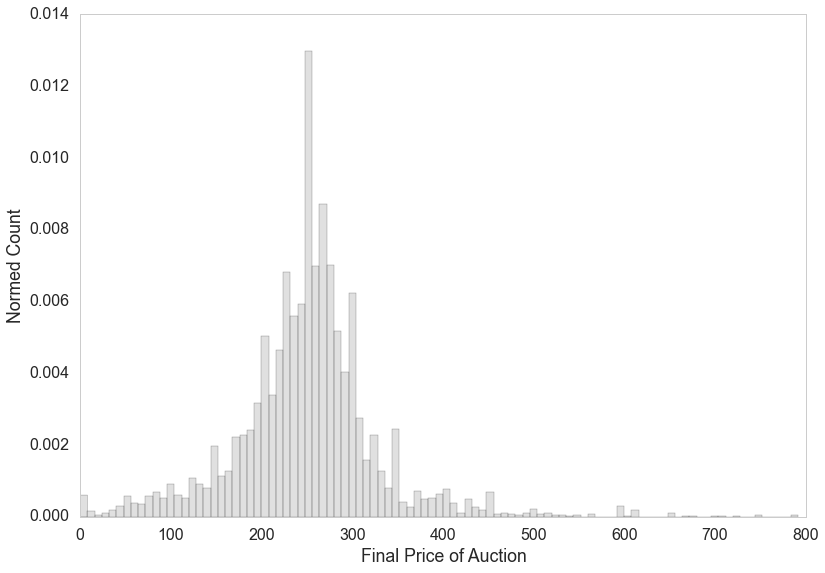

In [68]:
#Plotting histogram of selling prices
fig, ax1 = plt.subplots(figsize = (13,9))
ax1.grid(False)
ax1.xaxis.grid(False)
#ax1.yaxis.grid(b=False)
plt.hist(dftouse['FinalPrice'], bins = range(0,800,8),normed=True,zorder=0,color=dark_colors[1], alpha=.4);
ax1.set_xlabel("Final Price of Auction");
ax1.set_ylabel("Normed Count");


Looks like that value is centered right around 250. Good to know! Let's see if we can figure out when it is good to sell or not. Continue on to part 3 -- text_analysis.